In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(25) 
tamaño = 4
n = 25 - tamaño
# La red esperar una entrada con dimensiones (características, tamaño, lote).
X =  Array{Float32}(undef, 1, tamaño, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    ventana = fib[i:i+tamaño-1]
    etiqueta = fib[i+tamaño]
    X[1, : , i] .= ventana
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 1, identity; use_bias = false); return_sequence = false)
)

rng = Random.default_rng()
ps, st = Lux.setup(rng, modelo)

┌ Warning: `replicate` doesn't work for `TaskLocalRNG`. Returning the same `TaskLocalRNG`.
└ @ LuxCore ~/.julia/packages/LuxCore/qsnGJ/src/LuxCore.jl:18


((layer_1 = (weight_ih = Float32[-1.2010412;;], weight_hh = Float32[-0.9762399;;]),), (layer_1 = (rng = TaskLocalRNG(),),))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

8.519881f8

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.1f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 7.656195e8


Época 2 | coste = 6.868078e8
Época 3 | coste = 6.1578266e8
Época 4 | coste = 5.528457e8
Época 5 | coste = 4.9821443e8
Época 6 | coste = 4.518347e8
Época 7 | coste = 4.1315382e8
Época 8 | coste = 3.808446e8
Época 9 | coste = 3.525267e8
Época 10 | coste = 3.2467046e8
Época 11 | coste = 2.9299354e8
Época 12 | coste = 2.5350866e8
Época 13 | coste = 2.0395848e8
Época 14 | coste = 1.4526507e8
Época 15 | coste = 8.29799e7
Época 16 | coste = 2.876353e7
Época 17 | coste = 704920.44
Época 18 | coste = 1.6775991e7
Época 19 | coste = 6.979789e7
Época 20 | coste = 1.1075226e8
Época 21 | coste = 1.0635918e8
Época 22 | coste = 7.0246216e7
Época 23 | coste = 3.0465002e7
Época 24 | coste = 5.6846605e6
Época 25 | coste = 301581.66
Época 26 | coste = 8.947016e6
Época 27 | coste = 2.315259e7
Época 28 | coste = 3.5878504e7
Época 29 | coste = 4.305239e7
Época 30 | coste = 4.332762e7
Época 31 | coste = 3.7345652e7
Época 32 | coste = 2.7100008e7
Época 33 | coste = 1.5455547e7
Época 34 | coste = 5.633036e6
Ép

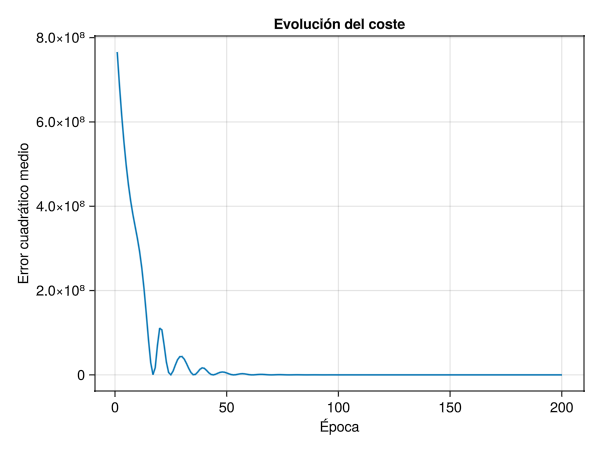

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

In [8]:
fib = fibonacci(30)
X_test = reshape(fib[end-tamaño : end-1], 1, tamaño, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])
println("Término 30 de la sucesión de Fibonacci: ", fib[end])

Predicción del término 30: 832064.56
Término 30 de la sucesión de Fibonacci: 832040.0


In [9]:
println("Pesos de la entrada de la red neuronal:", ps.layer_1.weight_ih)
println("Pesos del estado de la red neuronal:", ps.layer_1.weight_hh)

Pesos de la entrada de la red neuronal:Float32

[-0.63701445;;]
Pesos del estado de la red neuronal:Float32[-2.70253;;]


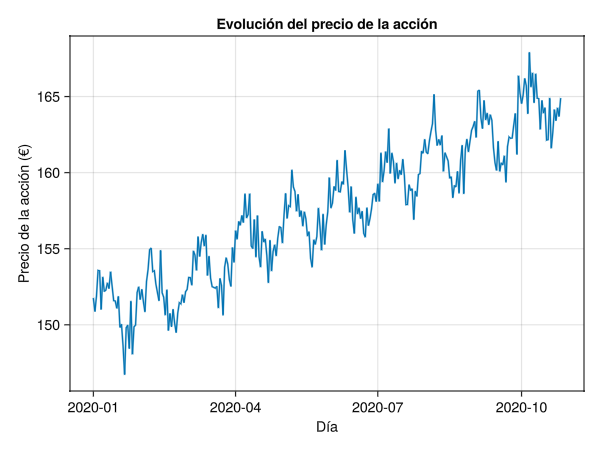

In [10]:
using CSV, DataFrames, GLMakie

# Cargamos el conjunto de datos en un data frame
df = CSV.read("datos/stock.csv", DataFrame)

# Creamos el gráfico de la evolución
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Día", ylabel = "Precio de la acción (€)", title = "Evolución del precio de la acción")

lines!(ax, df.dia, df.precio)
fig

In [11]:
using Statistics

# Simple normalization (z-score)
μ = mean(df.precio)
σ = std(df.precio)
serie = (df.precio .- μ) ./ σ     

300-element Vector{Float64}:
 -1.2770239698472932
 -1.4749432268197025
 -1.2481144154580652
 -0.8745140202741842
 -0.8789616440263692
 -1.4460336724304748
 -0.9679141190701513
 -1.1814000591752272
 -1.1591619404142832
 -1.054642782237841
 -1.1391476335294317
 -0.8923045152829369
 -1.1035666435119202
  ⋮
  1.4249074596075517
  1.5049646871469575
  1.031292757538819
  1.0379641931671029
  1.6472886472170039
  0.9112069162297167
  1.1469309750957366
  1.4782789446338223
  1.3137168658028255
  1.5027408752708586
  1.3759835983334725
  1.6450648353409114

In [12]:
function crear_secuencias(serie, tamaño)
    # Número de ventanas
    n = length(serie) - tamaño  

    # X: (características=1, tamaño=seq_len, lotes=n)
    X = Array{Float32}(undef, 1, tamaño, n)
    # Y: (etiquetas=1, lotes=n)
    Y = Array{Float32}(undef, 1, n)

    for i in 1:n
        ventana = serie[i : i + tamaño - 1]
        etiqueta = serie[i + tamaño]
        X[1, :, i] .= ventana
        Y[1, i] = etiqueta
    end

    return X, Y
end

X, Y = crear_secuencias(serie, 50)

(Float32[-1.2770239 -1.4749433 … -1.7551435 -1.501629;;; -1.4749433 -1.2481145 … -1.501629 -1.6973244;;; -1.2481145 -0.87451404 … -1.6973244 -1.4393623;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[-1.6973244 -1.4393623 … 1.3759836 1.6450648])

In [13]:
Xentrenamiento, Yentrenamiento = X[:, :, 1:200], Y[:, 1:200]
Xtest, Ytest = X[:, :, 201:end], Y[:, 201:end]

(Float32[0.08839652 0.09062033 … 1.3515216 1.1980786;;; 0.09062033 0.3797159 … 1.1980786 1.6117077;;; 0.3797159 0.29298723 … 1.6117077 1.3248359;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[1.6117077 1.3248359 … 1.3759836 1.6450648])

In [14]:
using Lux, Random
modelo = Chain(
    Recurrence(RNNCell(1 => 32); return_sequence = false),
    Dense(32 => 1)
)

rng = Random.default_rng()
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-0.30578703; -0.3942726; … ; 0.0951695; -0.2504706;;], weight_hh = Float32[-0.42600197 -0.34869406 … -0.02042546 -0.22588739; -0.0481861 -0.6633218 … -0.60480684 0.13100123; … ; 0.3998462 -0.53130686 … -0.11832127 -0.07518398; 0.15557154 -0.815116 … 0.16150872 -0.709026], bias_ih = Float32[0.37669295, 0.35555604, 0.007629254, -0.1983156, 0.3250256, 0.023860132, 0.45753506, -0.50156236, -0.42379928, -0.5070857  …  -0.39714718, -0.37166718, -0.10831991, -0.2590028, -0.17443208, -0.16104458, -0.28625938, -0.1979967, -0.28868192, -0.08755217], bias_hh = Float32[-0.11465098, -0.49581325, -0.13297853, -0.0049207923, -0.47189167, -0.10381557, -0.330212, 0.44374153, -0.1262013, -0.6803173  …  -0.19797993, -0.23783222, -0.096622474, -0.5007248, 0.43474782, -0.28186822, -0.6850097, -0.34075657, 0.01834882, -0.63372594]), layer_2 = (weight = Float32[0.0523473 0.1793634 … 0.124226205 0.10313724], bias = Float32[0.12541631])), (layer_1 = (rng = TaskLocalRNG(),), lay

In [15]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

1.7379391f0

In [16]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 300
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, Xentrenamiento, Yentrenamiento), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, Xentrenamiento, Yentrenamiento))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 0.7662999


Época 2 | coste = 0.5729446
Época 3 | coste = 0.58671606
Época 4 | coste = 0.67709863
Época 5 | coste = 0.7069613
Época 6 | coste = 

0.6878225
Época 7 | coste = 0.6167313
Época 8 | coste = 0.5466523
Época 9 | coste = 0.50364023
Época 10 | coste = 0.49563923
Época 11 | coste = 0.5014146
Época 12 | coste = 0.4965365
Época 13 | coste = 0.48724204
Época 14 | coste = 

0.45962405
Época 15 | coste = 0.43987876
Época 16 | coste = 0.4246907
Época 17 | coste = 0.40253273
Época 18 | coste = 0.37573487
Época 19 | coste = 0.34637368
Época 20 | coste = 0.2945349
Época 21 | coste = 0.21205603


Época 22 | coste = 0.15759636
Época 23 | coste = 0.13120647
Época 24 | coste = 0.118135035
Época 25 | coste = 0.111031696
Época 26 | coste = 0.107521795
Época 27 | coste = 0.10746923
Época 28 | coste = 0.10732585
Época 29 | coste = 0.10627311
Época 30 | coste = 0.097991124
Época 31 | coste = 0.092934705
Época 32 | coste = 0.08874322
Época 33 | coste = 0.085706174
Época 34 | coste = 0.08503921
Época 35 | coste = 0.082456075
Época 36 | coste = 0.08112205
Época 37 | coste = 0.082024194
Época 38 | coste = 0.081089
Época 39 | coste = 0.07997462
Época 40 | coste = 0.07946043
Época 41 | coste = 0.07694775
Época 42 | coste = 0.075592
Época 43 | coste = 0.07522486
Época 44 | coste = 

0.074397884
Época 45 | coste = 0.07329226
Época 46 | coste = 0.07376095
Época 47 | coste = 0.074136764
Época 48 | coste = 0.07385791
Época 49 | coste = 0.07395814
Época 50 | coste = 0.07383935
Época 51 | coste = 0.07310526
Época 52 | coste = 0.07253602
Época 53 | coste = 0.071235746
Época 54 | coste = 0.07074739
Época 55 | coste = 0.07170973
Época 56 | coste = 0.07186719
Época 57 | coste = 0.071634226
Época 58 | coste = 0.07123863
Época 59 | coste = 0.07156744
Época 60 | coste = 0.07147279
Época 61 | coste = 0.07132141
Época 62 | coste = 0.07123406
Época 63 | coste = 0.07122262
Época 64 | coste = 0.07108123
Época 65 | coste = 0.07083967
Época 66 | coste = 0.06955266
Época 67 | coste = 0.069372386


Época 68 | coste = 0.06914688
Época 69 | coste = 0.06903264
Época 70 | coste = 0.06901142
Época 71 | coste = 0.06895724
Época 72 | coste = 0.06888458
Época 73 | coste = 0.06884093
Época 74 | coste = 0.068757534
Época 75 | coste = 0.06860504
Época 76 | coste = 0.06847825
Época 77 | coste = 0.06841676
Época 78 | coste = 0.06835366
Época 79 | coste = 0.06826943
Época 80 | coste = 0.06820261
Época 81 | coste = 0.068140365
Época 82 | coste = 0.06805675
Época 83 | coste = 0.06798382
Época 84 | coste = 0.06793759
Época 85 | coste = 0.06787902
Época 86 | coste = 0.06779892
Época 87 | coste = 0.06772598
Época 88 | coste = 0.06765788
Época 89 | coste = 0.067175835
Época 90 | coste = 

0.067101814
Época 91 | coste = 0.06706145
Época 92 | coste = 0.06701799
Época 93 | coste = 0.066953264
Época 94 | coste = 0.06721088
Época 95 | coste = 0.06715985
Época 96 | coste = 0.06710007
Época 97 | coste = 0.067030504
Época 98 | coste = 0.06697916
Época 99 | coste = 0.06693616
Época 100 | coste = 0.06687715
Época 101 | coste = 0.06681591
Época 102 | coste = 0.066765934
Época 103 | coste = 0.066713296
Época 104 | coste = 0.06665643
Época 105 | coste = 0.066606395
Época 106 | coste = 0.06655488
Época 107 | coste = 0.06649494
Época 108 | coste = 0.06665367
Época 109 | coste = 0.06659772
Época 110 | coste = 0.06654063
Época 111 | coste = 0.0664719
Época 112 | coste = 0.066403635
Época 113 | coste = 0.06633856


Época 114 | coste = 0.066267826
Época 115 | coste = 0.0661969
Época 116 | coste = 0.06612998
Época 117 | coste = 0.066058904
Época 118 | coste = 0.06598523
Época 119 | coste = 0.06591555
Época 120 | coste = 0.064756416
Época 121 | coste = 0.06467703
Época 122 | coste = 0.064595655
Época 123 | coste = 0.06451131
Época 124 | coste = 0.064427204
Época 125 | coste = 0.06434851
Época 126 | coste = 0.0642709
Época 127 | coste = 0.06418938
Época 128 | coste = 0.064103015
Época 129 | coste = 0.06400712
Época 130 | coste = 0.063896514
Época 131 | coste = 0.06376724
Época 132 | coste = 0.06424142
Época 133 | coste = 0.06393773
Época 134 | coste = 0.063286684
Época 135 | coste = 0.06328013
Época 136 | coste = 

0.06293564
Época 137 | coste = 0.06265852
Época 138 | coste = 0.062881455
Época 139 | coste = 0.062095724
Época 140 | coste = 0.06284513
Época 141 | coste = 0.06322097
Época 142 | coste = 0.06348109
Época 143 | coste = 0.06145319
Época 144 | coste = 0.06271181
Época 145 | coste = 0.063829705
Época 146 | coste = 0.06252554
Época 147 | coste = 0.06311779
Época 148 | coste = 0.061398335
Época 149 | coste = 0.06253785
Época 150 | coste = 0.061723858
Época 151 | coste = 0.06197168
Época 152 | coste = 0.061636742
Época 153 | coste = 0.06131188
Época 154 | coste = 0.061417926
Época 155 | coste = 0.06077762
Época 156 | coste = 0.061261162
Época 157 | coste = 0.060662027
Época 158 | coste = 

0.06081418
Época 159 | coste = 0.05977533
Época 160 | coste = 0.05989063
Época 161 | coste = 0.060245663
Época 162 | coste = 0.059436698
Época 163 | coste = 0.06043458
Época 164 | coste = 0.062252775
Época 165 | coste = 0.061653245
Época 166 | coste = 0.06272736
Época 167 | coste = 0.06183119
Época 168 | coste = 0.06177959
Época 169 | coste = 0.061335932
Época 170 | coste = 0.060746726
Época 171 | coste = 0.06115575
Época 172 | coste = 0.060131963
Época 173 | coste = 0.060923953
Época 174 | coste = 0.060380667
Época 175 | coste = 0.059705883
Época 176 | coste = 0.060191143
Época 177 | coste = 0.05974182
Época 178 | coste = 0.059303675
Época 179 | coste = 0.060138486
Época 180 | coste = 0.060058378
Época 181 | coste = 0.059209734


Época 182 | coste = 0.060495447
Época 183 | coste = 0.060707852
Época 184 | coste = 0.059671227
Época 185 | coste = 0.059849206
Época 186 | coste = 0.061082914
Época 187 | coste = 0.06279092
Época 188 | coste = 0.062459644
Época 189 | coste = 0.061485294
Época 190 | coste = 0.062280092
Época 191 | coste = 0.062028293
Época 192 | coste = 0.05984713
Época 193 | coste = 0.059808716
Época 194 | coste = 0.05885806
Época 195 | coste = 0.059394762
Época 196 | coste = 0.058176417
Época 197 | coste = 0.058145195
Época 198 | coste = 0.058029734
Época 199 | coste = 0.058108993
Época 200 | coste = 0.05940045
Época 201 | coste = 0.06245913
Época 202 | coste = 0.06283896
Época 203 | coste = 0.06550986


Época 204 | coste = 0.06473067
Época 205 | coste = 0.0648022
Época 206 | coste = 0.064611055
Época 207 | coste = 0.064442456
Época 208 | coste = 0.06395203
Época 209 | coste = 0.06294839
Época 210 | coste = 0.06229295
Época 211 | coste = 0.06568294
Época 212 | coste = 0.06721835
Época 213 | coste = 0.07001159
Época 214 | coste = 0.0683642
Época 215 | coste = 0.06792946
Época 216 | coste = 0.06741994
Época 217 | coste = 0.06706037
Época 218 | coste = 0.06716643
Época 219 | coste = 0.06658665
Época 220 | coste = 0.066491626
Época 221 | coste = 0.06609613
Época 222 | coste = 0.06540191
Época 223 | coste = 0.06520477
Época 224 | coste = 0.06474287
Época 225 | coste = 0.06456783
Época 226 | coste = 

0.06438557
Época 227 | coste = 0.064088315
Época 228 | coste = 0.06444518
Época 229 | coste = 0.06692115
Época 230 | coste = 0.07464466
Época 231 | coste = 0.07440268
Época 232 | coste = 0.07198806
Época 233 | coste = 0.06953536
Época 234 | coste = 0.06977839
Época 235 | coste = 0.06908772
Época 236 | coste = 0.066321164
Época 237 | coste = 0.06605804
Época 238 | coste = 0.06721681
Época 239 | coste = 0.06747514
Época 240 | coste = 0.06785554
Época 241 | coste = 0.067567155
Época 242 | coste = 0.06543465
Época 243 | coste = 0.06352212
Época 244 | coste = 0.06259964
Época 245 | coste = 0.06287384
Época 246 | coste = 0.06400852
Época 247 | coste = 0.06384479
Época 248 | coste = 

0.06303738
Época 249 | coste = 0.06261508
Época 250 | coste = 0.06409832
Época 251 | coste = 0.080446646
Época 252 | coste = 0.070803925
Época 253 | coste = 0.07344653
Época 254 | coste = 0.064224
Época 255 | coste = 0.06827102
Época 256 | coste = 0.066549525
Época 257 | coste = 0.06368547
Época 258 | coste = 0.06701084
Época 259 | coste = 0.06388914
Época 260 | coste = 0.064374164
Época 261 | coste = 0.06576196
Época 262 | coste = 0.063541606
Época 263 | coste = 0.06350492
Época 264 | coste = 0.064361036
Época 265 | coste = 0.063481204
Época 266 | coste = 0.06300828
Época 267 | coste = 0.06292043
Época 268 | coste = 0.0625426
Época 269 | coste = 0.062155474
Época 270 | coste = 0.0619809
Época 271 | coste = 0.06169993


Época 272 | coste = 0.061314005
Época 273 | coste = 0.060780622
Época 274 | coste = 0.060954608
Época 275 | coste = 0.06083037
Época 276 | coste = 0.060017444
Época 277 | coste = 0.060354903
Época 278 | coste = 0.06021049
Época 279 | coste = 0.05974288
Época 280 | coste = 0.059807096
Época 281 | coste = 0.059584256
Época 282 | coste = 0.05930958
Época 283 | coste = 0.059204035
Época 284 | coste = 0.058978084
Época 285 | coste = 0.058882426
Época 286 | coste = 0.05852122
Época 287 | coste = 0.05843027
Época 288 | coste = 0.05817521
Época 289 | coste = 0.057861995
Época 290 | coste = 0.057767585
Época 291 | coste = 0.057557832
Época 292 | coste = 0.057242278
Época 293 | coste = 0.056962892


Época 294 | coste = 0.056652065
Época 295 | coste = 0.056590844
Época 296 | coste = 0.056785002
Época 297 | coste = 0.056117114
Época 298 | coste = 0.056435075
Época 299 | coste = 0.055898115
Época 300 | coste = 0.05529564


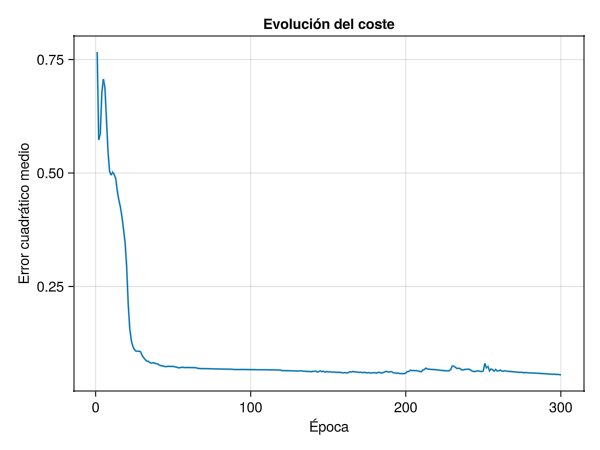

In [17]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

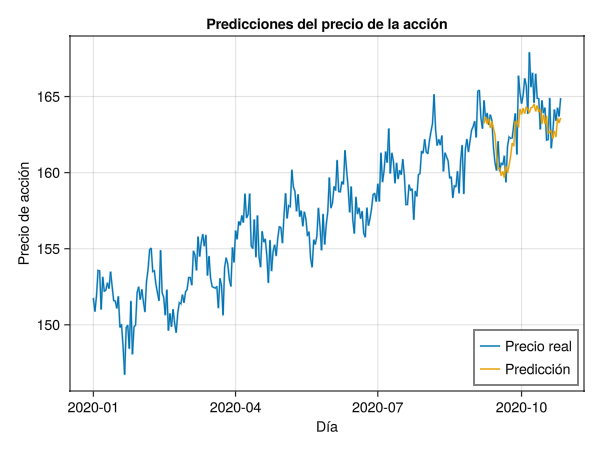

In [18]:
y_test, _ = modelo(Xtest, ps, st)
predicciones = y_test .* σ .+ μ

fig = Figure()
ax = Axis(fig[1,1], xlabel = "Día", ylabel = "Precio de acción", title = "Predicciones del precio de la acción")
lines!(ax, df.dia, df.precio, label = "Precio real")
lines!(ax, df.dia[251:end], vec(predicciones), label = "Predicción")
axislegend(ax, position = :rb)
fig